In [2]:
import numpy as np
import pandas as pd
import math

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

from tqdm.notebook import tqdm as pb

In [3]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
M = df.values
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


In [4]:
def plot_points(M, s, color=[]):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
    if len(color) == 0:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3])
    else:
        scat = ax.scatter(M[:,1], M[:,2],s=s*M[:,3], c=color)

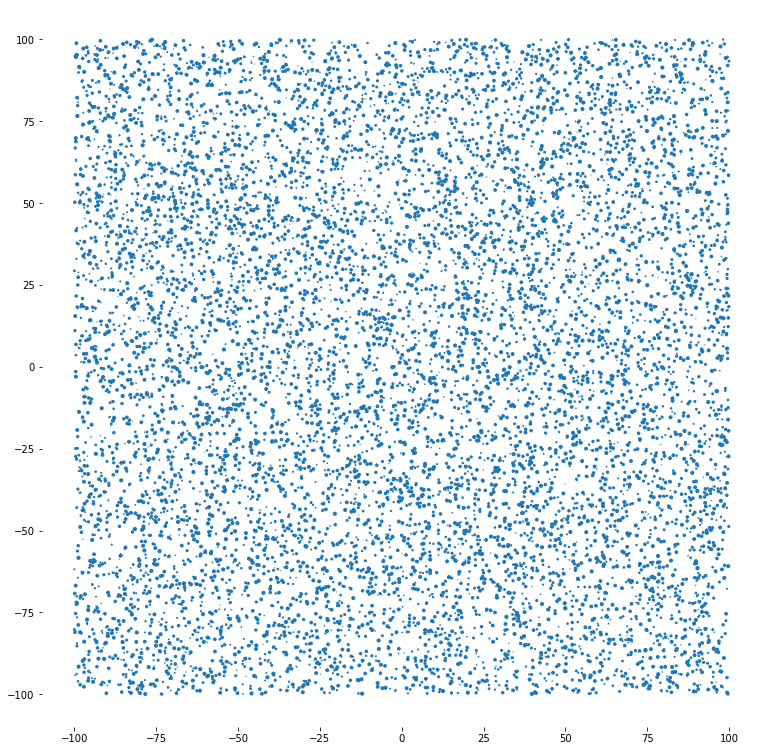

In [5]:
plot_points(M, 0.1)

In [6]:
def get_sub_section(M, coord1, coord2):
    indices = []
    for i in range(M.shape[0]):
        if M[i,1] >= coord1[0] and M[i,1] <= coord2[0] and M[i, 2] >= coord1[1] and M[i, 2] <= coord2[1]:
            indices.append(i)
    # colors
    colors = np.zeros((M.shape[0]))
    for i in indices:
        colors[i] = 1
    return np.copy(M)[indices,:], colors

In [7]:
M_sub, colors = get_sub_section(M, (-10.,-10.), (10.,10.))

In [8]:
M_sub.shape

(100, 4)

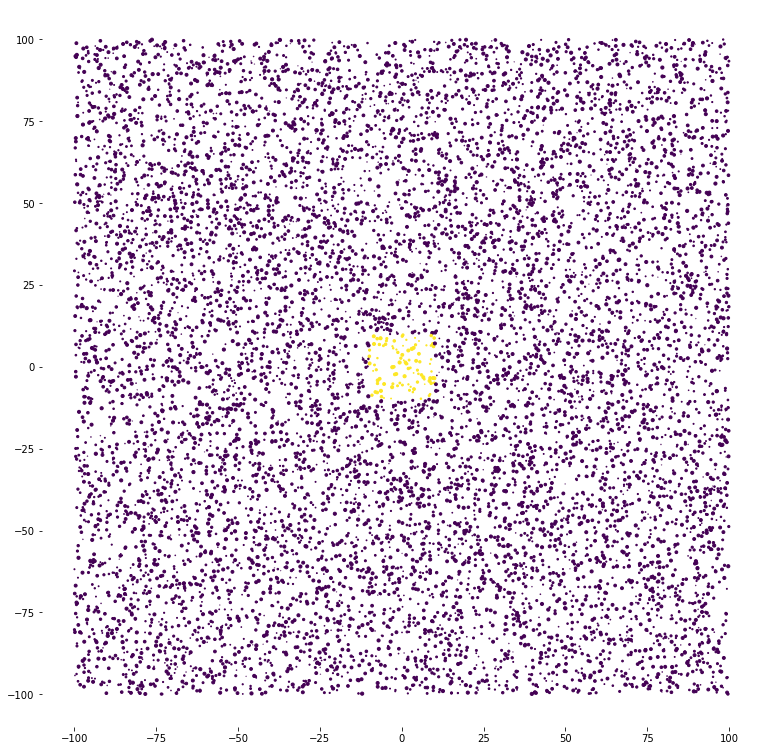

In [9]:
plot_points(M, 0.1, colors)

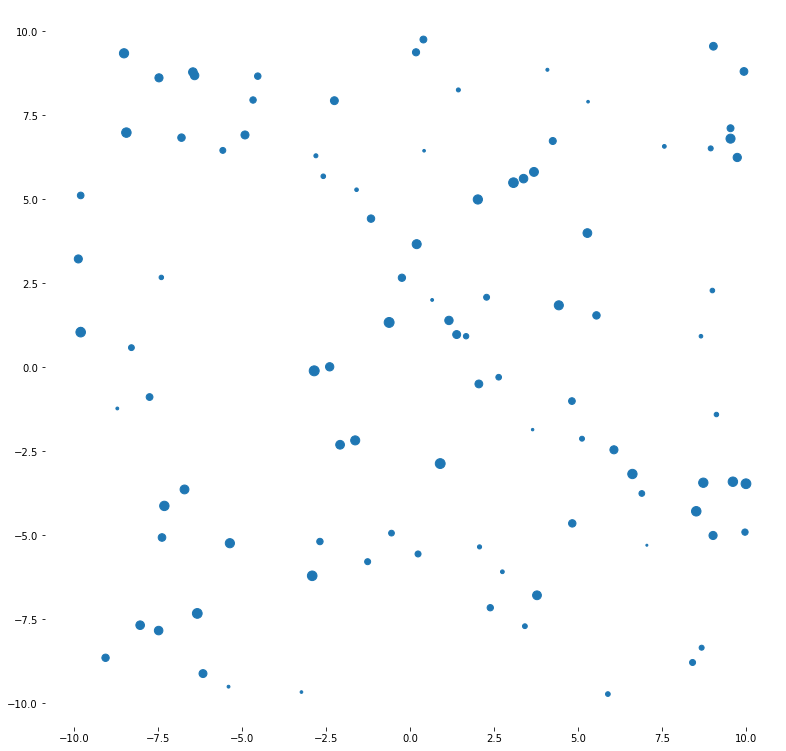

In [10]:
plot_points(M_sub, 1)

In [11]:
def create_dist_matrix(M):
    dim = M.shape[0]
    dist_M = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            dist_M[i,j] = math.sqrt((M[i,1] - M[j,1])**2 + (M[i,2] - M[j,2])**2)
    return dist_M

In [12]:
M_sub_dist = create_dist_matrix(M_sub)
M_sub_dist.shape

(100, 100)

In [13]:
_max_time = 100.
_init_pos = (0,0)

In [14]:
counter = 0

counter += 1 if counter < len(ids) - 1 else 0
colors = np.zeros((M_sub.shape[0]))
for i in range(M_sub.shape[0]):
    if i in ids[:counter]:
        colors[i] = 1
plot_points(M_sub, 5, colors)

In [32]:
def evaluate(M, M_dist, init_distance, _max_time, ks, path_lengths, iteration_validation):
    init_distance = np.zeros((M_dist.shape[0]))
    for i in range(M.shape[0]):
        init_distance[i] = math.sqrt((_init_pos[0] - M[i, 1])**2+(_init_pos[1] - M[i, 2])**2)
    def compute(M, M_dist, init_dist, init_pos, max_time):
        ids = []
        time = 0.
        choice = np.array([M[i, 3] / init_dist[i]**3 if init_dist[i] != 0. else 0.  for i in range(init_dist.shape[0])])
        action = np.argmax(choice)
        distance = init_dist[action]
        while time + distance < max_time:
            time += distance
            ids.append(action)
            M[action, 3] = 0
            _previous_action = action

            choice = np.array([M[i, 3] / M_dist[_previous_action,i]**3 if M_dist[_previous_action,i] != 0. else 0. for i in range(M_dist.shape[1])])
            action = np.argmax(choice)
            distance = M_dist[_previous_action,action]
        return ids, time
    
    ids_1, time_1 = compute(np.copy(M), np.copy(M_dist), init_distance, _init_pos, _max_time)
    
    # our metric
    def ant_exploration(M, M_dist, max_dist, k, max_edges, max_reward):
        def get_inverse_probabilities(array):
            sum_ = np.sum(array)
            prob = np.array([i/sum_ for i in array])
            if np.sum(prob) != 1.0:
                prob[-1] -= np.sum(prob) - 1.0
            for i in range(prob.shape[0]):
                prob[i] = -1 * np.log(prob[i])
            sum_ = np.sum(prob)
            prob = np.array([i/sum_ for i in prob])
            if np.sum(prob) != 1.0:
                prob[-1] -= np.sum(prob) - 1.0
            return prob
        
        sum_reward = np.sum(M[:,3])
        exploration_rate = 1.
        ant_exploration = np.zeros(M_dist.shape)
        for step in range(k):
            # find path
            vertice = np.random.choice(np.arange(M_dist.shape[0]), 1)[0]
            edges = []
            vertices = [vertice]

            for i in range(max_edges):
                choices = list(range(M_dist.shape[0]))
                for v in vertices:
                    choices.remove(v)
                if np.random.rand() <= exploration_rate:
                    vertices.append(np.random.choice(choices,1)[0])
                    edges.append((vertice, vertices[-1]))
                    vertice = vertices[-1]
                else:
                    soft = get_inverse_probabilities(M_dist[vertice, choices])
                    vertices.append(np.random.choice(choices,1,p=soft)[0])
                    edges.append((vertice, vertices[-1]))
                    vertice = vertices[-1]

            # retropopagate path gains
            mean_rewards = []
            mean_distances = []
            for i in edges:
                mean_rewards.append(M[i[1],3])
                mean_distances.append(M_dist[i[0],i[1]])
            mean_distances = sum(mean_distances)/len(mean_distances)
            mean_rewards = sum(mean_rewards)/len(mean_rewards)

            exploration_update = -1 * math.log(mean_distances/max_dist) * (mean_rewards / max_reward)

            probs = np.zeros((max_edges))
            for i in range(1,max_edges+1):
                probs[i-1] = math.sqrt(i/max_edges)
            for i in range(probs.shape[0]-1, 0, -1):
                probs[i] -= probs[i-1]
            if np.sum(probs) != 1.0:
                probs[-1] -= np.sum(probs) - 1.0
            for i, edge in enumerate(edges):
                ant_exploration[edge[0], edge[1]] += exploration_update * probs[i]

            exploration_rate -= 1/k
        return ant_exploration
    
    def compute(M, M_dist, init_dist, init_pos, max_time, weights):
        ids = []
        time = 0.
        action = np.argmin(init_dist)
        distance = init_dist[action]
        while time + distance < max_time:
            time += distance
            ids.append(action)
            M[action, 3] = 0
            _previous_action = action

            weights[:,_previous_action] = np.zeros((1,M_dist.shape[1]))
            action = np.argmax(weights[_previous_action])
            distance = M_dist[_previous_action, action]
        return ids, time
    
    validation = {}
    max_reward = np.max(M[:,3])
    for k in range(len(ks)):
        print("> K({})".format(ks[k]))
        for path_length in range(len(path_lengths)):
            print("   > Path({})".format(path_lengths[path_length]))
            validation["{}-{}".format(k,path_length)] = 0.
            for i in range(iteration_validation):
                ## FINIR METHODE PROBABILISTE POUR INVERSER LES PROBABILITES
                weights = ant_exploration(M, M_dist,_max_time, ks[k], path_lengths[path_length], max_reward)
                
                ids_2, _ = compute(np.copy(M), np.copy(M_dist), init_distance, _init_pos, _max_time, weights)
                validation["{}-{}".format(k,path_length)] += np.sum(M[ids_2,3])
            validation["{}-{}".format(k,path_length)] = validation["{}-{}".format(k,path_length)] / iteration_validation
    
    return [ids_1, time_1], validation

In [33]:
metric, ants = evaluate(np.copy(M_sub), np.copy(M_sub_dist), _init_pos, _max_time, [], 
            [3], 1)

> K(1000)
   > Path(3)
> K(2000)
   > Path(3)
> K(5000)
   > Path(3)
> K(10000)
   > Path(3)
> K(20000)
   > Path(3)


In [34]:
x_label = []
values = []
for i, val in enumerate(ants):
    x_label.append(val)
    values.append(ants[val])

<BarContainer object of 5 artists>

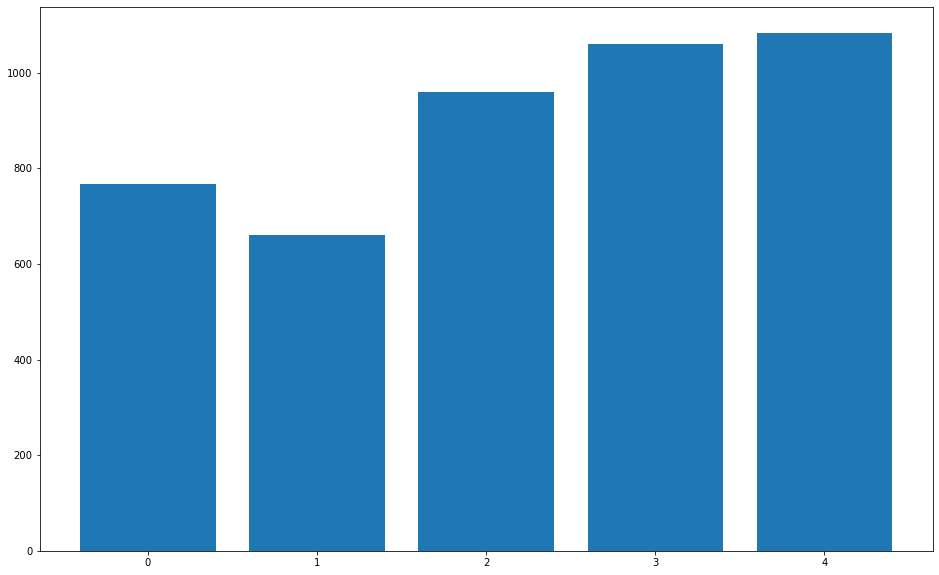

In [35]:
plt.bar(np.arange(len(values)), values)

In [24]:
print(np.sum(M[metric[0],3]))

2603.0
